In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("cleaned_data\\combined_GT_MD.csv")

In [3]:
data_image = data[['image', 'split', 'MEL', 'NV', 'BCC', 'BKL', 'other']].copy()
data_image.head()

,image,split,MEL,NV,BCC,BKL,other
0,ISIC_0012653_downsampled,val,0.0,1.0,0.0,0.0,0.0
1,ISIC_0012654_downsampled,train,0.0,1.0,0.0,0.0,0.0
2,ISIC_0012655_downsampled,train,0.0,1.0,0.0,0.0,0.0
3,ISIC_0012656_downsampled,test,0.0,1.0,0.0,0.0,0.0
4,ISIC_0012657_downsampled,train,0.0,1.0,0.0,0.0,0.0


In [4]:
data_image['class'] = data_image[['MEL', 'NV', 'BCC', 'BKL', 'other']].idxmax(axis=1)
balance_table = data_image.groupby(['split', 'class']).size().unstack()
print(balance_table)

class   BCC   BKL   MEL    NV  other
split                               
test    457   382   546  1622    368
train  2323  1669  2958  8015   1319
val     543   375   681  1689    300


## Creating DataFrames


In [5]:
df_train = data_image[data_image['split'] == 'train'].copy()
df_val = data_image[data_image['split'] == 'val'].copy()
df_test = data_image[data_image['split'] == 'test'].copy()
# Convert image names to string and append '.jpg'
df_train['image'] = df_train['image'].astype(str) + '.jpg'
df_val['image'] = df_val['image'].astype(str) + '.jpg'
df_test['image'] = df_test['image'].astype(str) + '.jpg'


## ImageDataGenerator

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='cleaned_data\\ISIC_2019_Training_Input_cleaned', 
    x_col='image',
    y_col=['MEL', 'NV', 'BCC', 'BKL', 'other'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='cleaned_data\\ISIC_2019_Training_Input_cleaned',
    x_col='image',
    y_col=['MEL', 'NV', 'BCC', 'BKL', 'other'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)


Found 16284 validated image filenames.
Found 3588 validated image filenames.


## CNN model

In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  
])


c:\AI4All project\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training with EarlyStopping and ModelCheckpoint

In [20]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.5532 - loss: 1.1732
Epoch 1: val_accuracy improved from -inf to 0.54849, saving model to best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 505s 991ms/step - accuracy: 0.5533 - loss: 1.1731 - val_accuracy: 0.5485 - val_loss: 1.1388
Epoch 2/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6434 - loss: 0.9436
Epoch 2: val_accuracy improved from 0.54849 to 0.56689, saving model to best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.6433 - loss: 0.9436 - val_accuracy: 0.5669 - val_loss: 1.1155
Epoch 3/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6846 - loss: 0.8228
Epoch 3: val_accuracy improved from 0.56689 to 0.60006, saving model to best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 3916s 8s/step - accuracy: 0.6846 - loss: 0.8228 - val_accuracy: 0.6001 - val_loss: 1.0867
Epoch 4/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7398 - loss: 0.6932
Epoch 4: val_accuracy did not im

<Axes: title={'center': 'Loss by Epoch'}>

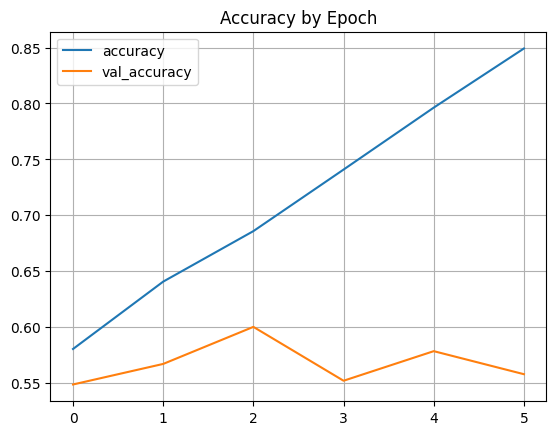

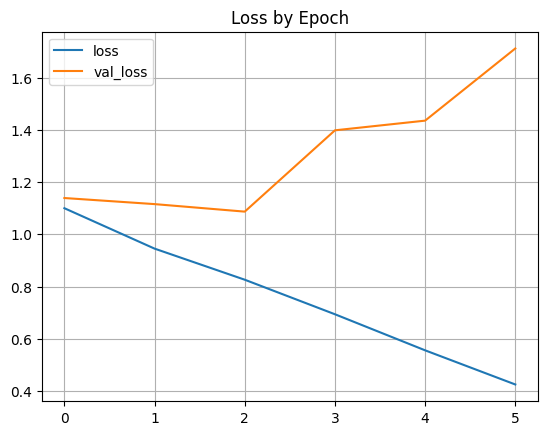

In [21]:
# Accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(
    title='Accuracy by Epoch', grid=True
)

#Loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(
    title='Loss by Epoch', grid=True
)

